# 정형 데이터 (Boston 집값 예측)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import warnings
import torch

warnings.filterwarnings('ignore')

In [ ]:
data = load_boston() #Boston 집값 예측

In [ ]:
df = pd.DataFrame(data['data'],columns=data['feature_names'])  # 데이터셋 불러오기
df['target'] = data['target']
print(df.shape)

(506, 14)


In [ ]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
Num_feature= len(df.drop('target',1).columns) # 컬럼수

In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

In [ ]:
class BostonData(Dataset): #Dataset의 속성들을 상속
  def __init__(self,data, target = 'target',normalize=True): # 데이터 불러오고 전처리하는 공간!
    self.x = data.drop(target,1)

    if normalize:
      scaler = StandardScaler()
      self.x = pd.DataFrame(scaler.fit_transform(self.x))

    self.y = data['target']

    #tensor 변환
    self.x=torch.tensor(self.x.values).float()
    self.y=torch.tensor(self.y).float()

  def __len__(self):  # 길이 반환
    return len(self.x)

  def __getitem__(self,idx): # item 반환
    x=self.x[idx]
    y=self.y[idx]

    return x,y

In [ ]:
dataset = BostonData(df, 'target', True) # 데이터셋 불러오기

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32,shuffle=True)  #데이터로더에 데이터 넣기

In [ ]:
x,y = next(iter(data_loader)) # batch된 데이터가 iterate하여 접근 할떄 사용

In [ ]:
x.shape, y.shape

(torch.Size([32, 13]), torch.Size([32]))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Reg(nn.Module):
  def __init__(self, num_features):  # 신경망 구성요소
    super(Reg,self).__init__()  #super로 부모 클래스를 상속.

    self.fc1=nn.Linear(num_features,32)
    self.fc2=nn.Linear(32,8)
    self.output=nn.Linear(8,1)
  
  def forward(self,x): #신경망 동작 정의
    x = F.relu(self.fc1(x)) # F -> nn은 클래스, F는 함수 형태 /nn은 인스턴스화 필요! init에서 모델을 정의
    x = F.relu(self.fc2(x))
    x = self.output(x)

    return x

In [ ]:
model = Reg(Num_feature)
model.to(device)
model

Reg(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.005)

In [ ]:
num_epoch = 200

losses = []
for epoch in range(num_epoch):
  running_loss=0

  for x,y in data_loader:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    y_hat = model(x)

    loss = criterion(y,y_hat)
    loss.backward()
    
    optimizer.step()

    running_loss += loss.item()

  loss = running_loss/len(data_loader)
  losses.append(loss)


  if epoch % 20 == 0:
    print("{0} loss = {1:.5f}".format(epoch,loss))

0 loss = 568.56064
20 loss = 87.05174
40 loss = 85.84340
60 loss = 85.28230
80 loss = 85.34918
100 loss = 85.72957
120 loss = 85.76276
140 loss = 84.33438
160 loss = 85.36539
180 loss = 85.21349


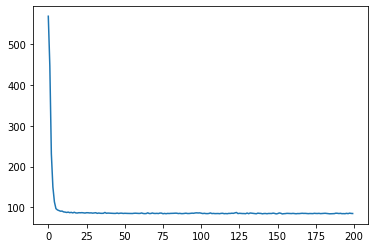

In [ ]:
plt.figure()
plt.plot(losses[:200])
plt.show()